## Final Project

##### Question: Build simulations to evaluate the impact of assortative mating (AM) on the true heritability and the HE regression heritability estimate.

#### Imports

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#### Class Definitions

In [ ]:
class Generation():

    def __init__(self, n, s_noncausal, s_causal):
        self.n = n
        self.s_noncausal = s_noncausal
        self.s_causal = s_causal
        self.s = s_noncausal + s_causal
        self.G = None
        self.standard_G = None
    
    # Part A
    def simulate_polygenic_trait(self, true_h2):
        # compute va and ve from true_h2
        ve = 1 - true_h2
        va = true_h2

        # simulate genotypes for each person for each SNP
        G = np.zeros((self.n, self.s))
        snp_ps = []
        for snp in range(self.s):
            p = np.random.uniform()
            snp_ps.append(p)
            s_array = np.array(np.random.binomial(2, p, size = self.n))
            G[:, snp] = s_array
        self.snp_ps = snp_ps

        # scale genotypes
        self.G = G.astype(int)
        standardized_G = StandardScaler().fit_transform(G)
        self.standard_G = standardized_G

        # choose causal SNPs and effect sizes
        causal_snps = np.random.choice(range(0, self.s), size=self.s_causal, replace=False)
        effect_sizes = list(np.random.normal(loc=0, scale = np.sqrt(va/self.s_causal), size=self.s_causal))

        causal_snp_effect = dict(zip(range(0, self.s), [0]*self.s))
        for k in list(causal_snp_effect.keys()):
            if k in causal_snps:
                causal_snp_effect[k] = effect_sizes[0]
                del effect_sizes[0]
        self.causal_snp_effect = causal_snp_effect

        # simulate phenotypes
        phenotypes = []
        phenotypes_causal = []
        phenotypes_noise = []
        for i, row in enumerate(self.standard_G):
            phenotype_causal = np.sum(np.array(row) * np.array(list(causal_snp_effect.values())))
            phenotype_noise = np.random.normal(loc=0, scale=np.sqrt(ve))
            phenotype = phenotype_causal + phenotype_noise
            phenotypes.append(phenotype)
            phenotypes_causal.append(phenotype_causal)
            phenotypes_noise.append(phenotype_noise)

        self.phenotypes = phenotypes
        self.genotypes = phenotypes_causal
        self.environment = phenotypes_noise

        return phenotypes_causal, phenotypes_noise, phenotypes
    
    # Part B
    @staticmethod
    def offspring_mendelian_genotypes_from_parents(par1_g, par2_g, num_offspring, true_h2):
        va = true_h2
        ve = 1 - true_h2
        offspring_g = []
        for i in range(num_offspring):
            g = np.random.normal(loc = 0.5*(par1_g + par2_g), scale = np.sqrt(va/2))
            offspring_g.append(g)
        if num_offspring == 1:
            return offspring_g[0]
        return offspring_g
    
    # Part C
    @staticmethod
    def offspring_snp_genotypes_from_parents(par1_g, par2_g):
        n_snps = par1_g.shape[0]

        # split parent alleles and choose randomly for child allele
        child_g = np.zeros(n_snps, dtype=int)
        for i in range(n_snps):
            alleles1 = [1] * par1_g[i] + [0] * (2 - par1_g[i])
            alleles2 = [1] * par2_g[i] + [0] * (2 - par2_g[i])
            np.random.shuffle(alleles1)
            np.random.shuffle(alleles2)

            a1 = np.random.choice(alleles1)
            a2 = np.random.choice(alleles2)
            child_g[i] = a1 + a2
        return child_g
    
    # Part C
    def add_to_genotype_matrix(self, child_G, n):
        if self.G is None:
            self.G = np.zeros((self.n, self.s))
        self.G[n, :] = child_G
        self.G = self.G.astype(int)
    
    # Part C
    def update_standard_genotype_matrix(self):
        standardized_G = StandardScaler().fit_transform(self.G)
        self.standard_G = standardized_G
    
    # Part C
    @staticmethod
    def he_regression(Y, K, n, phenotypes):
        i, j = np.triu_indices(n, k=1)
        slope = np.cov(Y[i, j], K[i, j])[0, 1] / np.var(K[i, j])
        h2_est = slope / np.var(phenotypes)
        return h2_est

In [4]:
class GenerationSimulator:

    def __init__(self, first_generation):
        self.first_generation = first_generation
        self.generations = [first_generation]
    
    # Part C
    def next_gen_simulator(self, parent_gen, true_h2, assorted, target_corr=0.3, tolerance=0.01):
        child_gen = Generation(parent_gen.n, parent_gen.s_noncausal, parent_gen.s_causal)

        if assorted:
            corr = 0
            # keep recalculating correlation until close enough to target correlation
            while abs(corr - target_corr) > tolerance:
                pairs, corr = GenerationSimulator.get_assortative_pairs(parent_gen.phenotypes, target_corr=target_corr, max_tries=1000)

            for i, (par1_idx, par2_idx) in enumerate(pairs):
                # choose parents with assortative mating
                par1_g = parent_gen.G[par1_idx, :]
                par2_g = parent_gen.G[par2_idx, :]

                # child 1
                child_G = Generation.offspring_snp_genotypes_from_parents(par1_g, par2_g)
                child_gen.add_to_genotype_matrix(child_G, i)

                # child 2 
                child_G = Generation.offspring_snp_genotypes_from_parents(par1_g, par2_g)
                child_gen.add_to_genotype_matrix(child_G, i+1)
        else:
            for i in range(0, child_gen.n, 2):
                # choose parents randomly
                par1, par2 = np.random.choice(range(parent_gen.n), replace=False, size=2)
                par1_g = parent_gen.G[par1, :]
                par2_g = parent_gen.G[par2, :]

                # child 1
                child_G = Generation.offspring_snp_genotypes_from_parents(par1_g, par2_g)
                child_gen.add_to_genotype_matrix(child_G, i)

                # child 2 
                child_G = Generation.offspring_snp_genotypes_from_parents(par1_g, par2_g)
                child_gen.add_to_genotype_matrix(child_G, i+1)
        
        child_gen.update_standard_genotype_matrix()
        
        # compute child genotypes
        genotypes = []
        for i, row in enumerate(child_gen.standard_G):
            genotype = np.sum(np.array(row) * np.array(list(self.first_generation.causal_snp_effect.values())))
            genotypes.append(genotype)
        child_gen.genotypes = genotypes

        # compute ve based on true_h2 and experimental va
        va = np.var(child_gen.genotypes)
        ve = va * ( (1 - true_h2) / true_h2)

        # simulate child environment and compute phenotype
        environment = []
        phenotypes = []
        for child in range(len(child_gen.genotypes)):
            child_g = child_gen.genotypes[child]
            child_e = np.random.normal(loc=0, scale=np.sqrt(ve))
            environment.append(child_e)
            phenotypes.append(child_g + child_e)
        child_gen.environment = environment
        child_gen.phenotypes = phenotypes

        # create kinship matrix with true genotype data (not kinship relationships)
        child_gen.K = np.dot(child_gen.standard_G, child_gen.standard_G.T) / child_gen.standard_G.shape[1]

        self.generations.append(child_gen)
        return child_gen
    
    @staticmethod
    def get_assortative_pairs(phenotypes, target_corr=0.3, max_tries=1000):
        phenotypes = np.array(phenotypes)
        n = len(phenotypes)

        sampled_indices = np.random.choice(n, size=n, replace=False)
        phenos_subset = phenotypes[sampled_indices]

        # sort sampled phenotypes and split into two
        sorted_local_indices = np.argsort(phenos_subset)
        sorted_indices = sampled_indices[sorted_local_indices]

        # create initial index pairings (first half with second half)
        p1_idx = sorted_indices[:n // 2].copy()
        p2_idx = sorted_indices[n // 2:].copy()

        # compute initial correlation
        p1_vals = phenotypes[p1_idx]
        p2_vals = phenotypes[p2_idx]
        initial_corr = np.corrcoef(p1_vals, p2_vals)[0, 1]

        for i in range(max_tries):
            prev_corr = np.corrcoef(phenotypes[p1_idx], phenotypes[p2_idx])[0, 1]

            # swap one random pair
            pair_idx = np.random.randint(len(p1_idx))
            p1_idx[pair_idx], p2_idx[pair_idx] = p2_idx[pair_idx], p1_idx[pair_idx]

            # compute new correlation
            new_corr = np.corrcoef(phenotypes[p1_idx], phenotypes[p2_idx])[0, 1]

            # check if we crossed the target correlation
            crossed = (prev_corr > target_corr and new_corr < target_corr) or (prev_corr < target_corr and new_corr > target_corr)
            if crossed:
                if abs(prev_corr - target_corr) < abs(new_corr - target_corr):
                    final_corr = prev_corr
                    # undo last shuffle to return previous state
                    p1_idx[pair_idx], p2_idx[pair_idx] = p2_idx[pair_idx], p1_idx[pair_idx]
                else:
                    final_corr = new_corr

                # return index-based pairs
                index_pairs = list(zip(p1_idx, p2_idx))
                return index_pairs, final_corr

        # if no crossing occurred after max_tries (not likely)
        final_corr = np.corrcoef(phenotypes[p1_idx], phenotypes[p2_idx])[0, 1]
        index_pairs = list(zip(p1_idx, p2_idx))
        return index_pairs, final_corr

    # Part C
    def run_gen_simulator(self, true_h2, num_generations, assorted=False, target_corr=0.3):
        parent_gen = self.first_generation
        self.num_generations = num_generations
        for i in range(num_generations-1):
            parent_gen = self.next_gen_simulator(parent_gen, true_h2, assorted, target_corr)
    
    def plot_mean_genotype_across_generations(self):
        mean_genotypes = []
        for gen in self.generations:
            mean_gen = np.mean(gen.genotypes)
            mean_genotypes.append(mean_gen)
        plt.plot(range(1, self.num_generations+1), mean_genotypes)
        plt.title('Average Genotype Across Generations')
        plt.xlabel('Generation')
        plt.ylabel('Average Genotype')
        plt.ylim(-0.3, 0.3)
    
    def plot_mean_phenotype_across_generations(self):
        mean_phenotypes = []
        for gen in self.generations:
            mean_phen = np.mean(gen.phenotypes)
            mean_phenotypes.append(mean_phen)
        plt.plot(range(1, self.num_generations+1), mean_phenotypes)
        plt.title('Average Phenotype Across Generations')
        plt.xlabel('Generation')
        plt.ylabel('Average Phenotype')
        plt.ylim(-0.3, 0.3)
    
    def plot_mean_environment_across_generations(self):
        mean_environment = []
        for gen in self.generations:
            mean_env = np.mean(gen.environment)
            mean_environment.append(mean_env)
        plt.plot(range(1, self.num_generations+1), mean_environment)
        plt.title('Average Environment Across Generations')
        plt.xlabel('Generation')
        plt.ylabel('Average Environment')
        plt.ylim(-0.3, 0.3)

    def plot_true_heritability(self):
        h2s = []
        for gen in self.generations:
            va = np.var(gen.genotypes)
            ve = np.var(gen.environment)
            h2 = va / (va + ve)
            h2s.append(h2)
        plt.plot(range(1, self.num_generations+1), h2s)
        plt.title('Experimental H2 Across Generations')
        plt.xlabel('Generation')
        plt.ylabel('Experimental H2')
        plt.ylim(0, 1)
    
    # Part C
    @staticmethod
    def many_sim_true_heritability(n, s_noncausal, s_causal, true_h2, num_sims=10, assorted=False, target_corr=0.3):
        all_sim_true_h2 = []
        for i in range(num_sims):
            first_gen = Generation(n, s_noncausal, s_causal)
            first_gen.simulate_polygenic_trait(true_h2)
            gen_sim = GenerationSimulator(first_gen)
            gen_sim.run_gen_simulator(true_h2, num_generations=10, assorted=assorted, target_corr=target_corr)
            h2s = []
            for gen in gen_sim.generations:
                va = np.var(gen.genotypes)
                ve = np.var(gen.environment)
                h2 = va / (va + ve)
                h2s.append(h2)
            all_sim_true_h2.append(h2s)
        
        for i, h2_list in enumerate(all_sim_true_h2):
            if i == 0:
                plt.plot(range(1, 11), h2_list, color = 'pink', label = 'Sim Exp. H2')
            else:
                plt.plot(range(1, 11), h2_list, color = 'pink')

        plt.plot(range(1, 11), [true_h2]*10, linestyle = '--', color = 'blue', label = 'True H2')

        average_h2s = [sum(x) / len(x) for x in zip(*all_sim_true_h2)]
        plt.plot(range(1, 11), average_h2s, color = 'red', label = 'Sim Exp. Average H2')


        plt.legend()
        plt.title('Experimental H2 For Many Simulations')
        plt.xlabel('Generation')
        plt.ylabel('Experimental H2')

        return average_h2s
    
    # Part C
    def many_sim_he_regression(n, s_noncausal, s_causal, true_h2, num_sims=10, assorted=False, target_corr=0.3):
        all_sim_he_regression = []
        for i in range(num_sims):
            first_gen = Generation(n, s_noncausal, s_causal)
            first_gen.simulate_polygenic_trait(true_h2)
            gen_sim = GenerationSimulator(first_gen)
            gen_sim.run_gen_simulator(true_h2, num_generations=10, assorted=assorted, target_corr=target_corr)
            h2s = []
            for i, gen in enumerate(gen_sim.generations):
                if i == 0:
                    gen.K = np.dot(first_gen.standard_G, first_gen.standard_G.T) / first_gen.standard_G.shape[1]
                K = gen.K
                Y = np.outer(np.array(gen.phenotypes), np.array(gen.phenotypes))
                h2_estimate = Generation.he_regression(Y, K, n, gen.phenotypes)
                h2s.append(h2_estimate)
            all_sim_he_regression.append(h2s)
        
        for i, h2_list in enumerate(all_sim_he_regression):
            if i == 0:
                plt.plot(range(1, 11), h2_list, color = 'lightgreen', label = 'Sim HE Regression H2')
            else:
                plt.plot(range(1, 11), h2_list, color = 'lightgreen')

        plt.plot(range(1, 11), [true_h2]*10, linestyle = '--', color = 'blue', label = 'True H2')

        average_h2s = [sum(x) / len(x) for x in zip(*all_sim_he_regression)]
        plt.plot(range(1, 11), average_h2s, color = 'green', label = 'Sim HE Regression Average H2')
        plt.legend()
        plt.title('HE Regression H2 For Many Simulations')
        plt.xlabel('Generation')
        plt.ylabel('HE Regression H2')

        return average_h2s

    @staticmethod
    def plot_true_h2_and_he_regression(true_average_h2s, he_average_h2s, true_h2):
        plt.plot(range(1, 11), true_average_h2s, color = 'red', label = 'Sim Exp. Average H2')
        plt.plot(range(1, 11), he_average_h2s, color = 'green', label = 'Sim HE Regression Average H2')
        plt.plot(range(1, 11), [true_h2]*10, linestyle = '--', color = 'blue', label = 'True H2')
        plt.legend()
        plt.title('Experimental H2 vs HE Regression H2')
        plt.xlabel('Generation')
        plt.ylabel('H2')


#### Answers to Problem

##### A: Simulate a polygenic trait with 500 causal SNP effects in a population of 1000 individuals. Assume all loci are independent, i.e., unlinked.

In [11]:
gen1 = Generation(n=1000, s_noncausal = 0, s_causal = 500)
phen_causal, phen_noise, phen = gen1.simulate_polygenic_trait(true_h2 = 0.3)

In [ ]:
print('The experimental heritability is ' + str(np.var(phen_causal) / np.var(phen)))

The experimental heritability is 0.3012427484174328


##### B: Write a function that simulates the genotypes of offspring from a set of parental genotypes via Mendelian transmission.

In [13]:
example_par1_g = 0.5
example_par2_g = 0.8
example_h2 = 0.01

print('Two Offspring Genotypes: ' + str(Generation.offspring_mendelian_genotypes_from_parents(example_par1_g, example_par2_g, 2, example_h2)))

Two Offspring Genotypes: [0.6307791595944509, 0.8382266851405858]


##### C: Simulate 10 generations under random mating. Plot the trajectory of the true heritability across generations. (This will require appropriately defining “true heritability”). Next, add the trajectory of HE regression estimates to your plot.

In [14]:
ten_gen_sim_random = GenerationSimulator(gen1)
ten_gen_sim_random.run_gen_simulator(true_h2=0.3, num_generations=10)

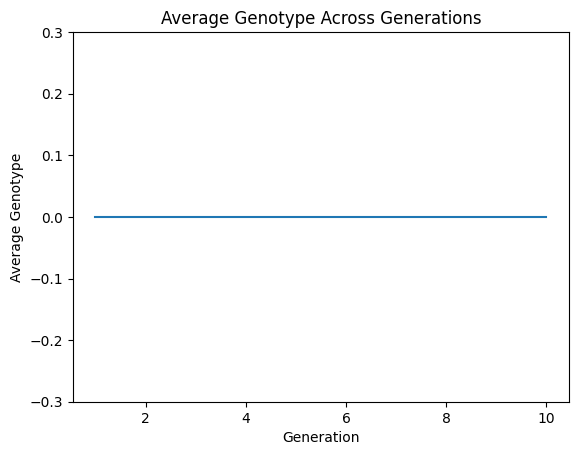

In [15]:
ten_gen_sim_random.plot_mean_genotype_across_generations()

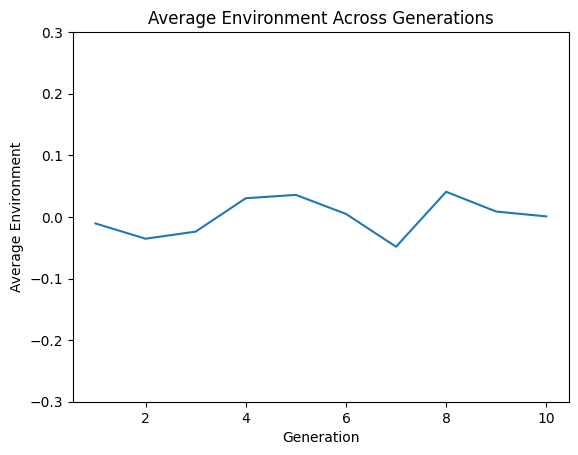

In [16]:
ten_gen_sim_random.plot_mean_environment_across_generations()

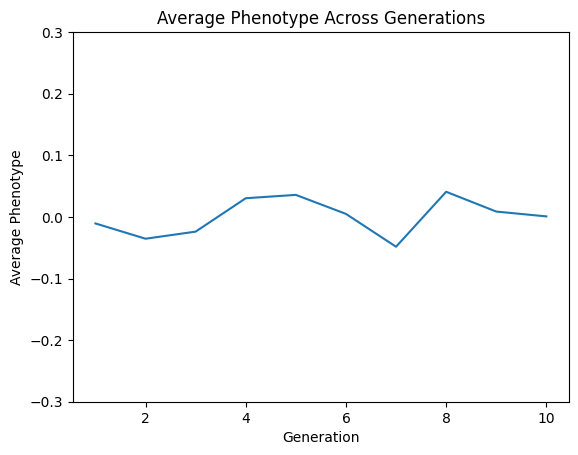

In [17]:
ten_gen_sim_random.plot_mean_phenotype_across_generations()

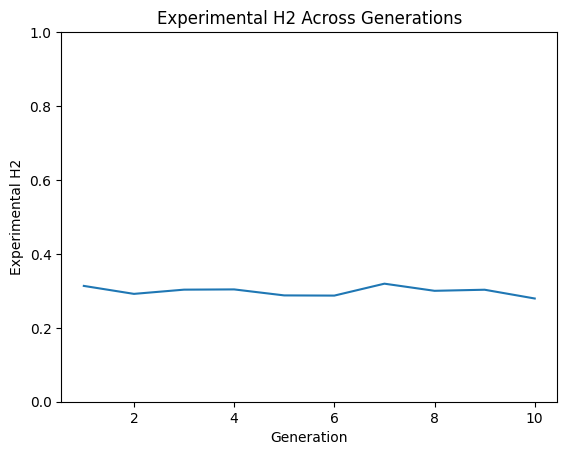

In [18]:
ten_gen_sim_random.plot_true_heritability()

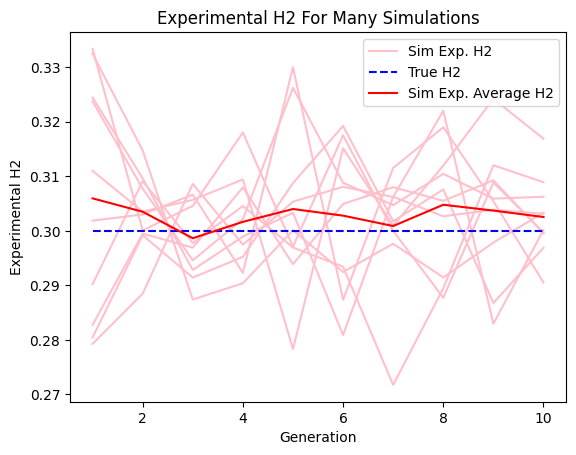

In [19]:
average_true_h2s = GenerationSimulator.many_sim_true_heritability(n=1000, s_noncausal=0, s_causal=500, true_h2=0.3, num_sims=10)

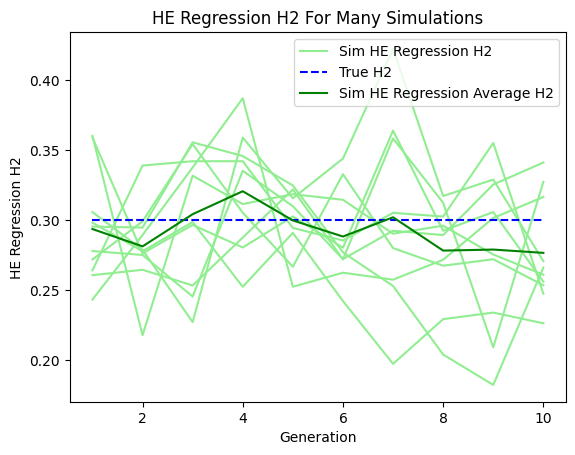

In [20]:
average_he_regression_h2s = GenerationSimulator.many_sim_he_regression(n=1000, s_noncausal=0, s_causal=500, true_h2=0.3, num_sims=10)

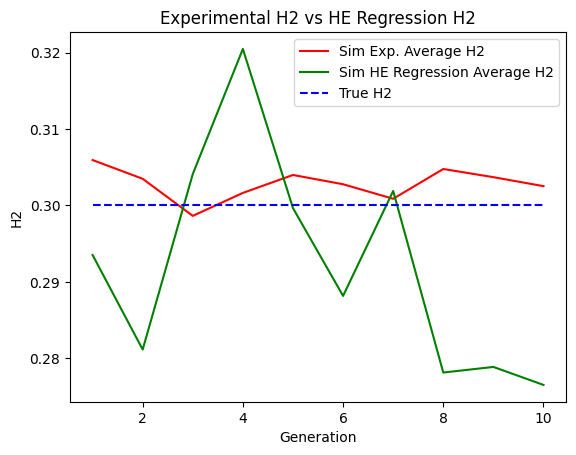

In [21]:
GenerationSimulator.plot_true_h2_and_he_regression(average_true_h2s, average_he_regression_h2s, true_h2=0.3)

##### This simulation shows random mating with 500 causal SNPs. The genotypes of the population have mean 0 through the generations, which makes sense as there is no fitness function to drive changes in the population. With a heritability of 0.3, the environmental variation is larger than the genetic variation, so the mean of the environmental values is centered at 0, but has more variability than the genotypes. Accordingly, phenotypic changes are driven by environmental changes (as genotype values have mean 0). In order to use heritability of 0.3 in the simulating of SNP by SNP genotypic transmission, I computed the variance of the genotypes of each generation and then appropriately defined ve = va * ( (1 - true_h2) / true_h2) so that the heritability would be consistent across generations. With random mating, the true experimental heritability (as calculated by va/vp) and the HE regression estimate using kinship (X*X^T/n_snps) and the phenotype matrix both estimate heritability without bias. The HE regression estimate is more noisy than calculating true experimental heritability,  but both are relatively precise (within 0.02 of the true heritability used in the simulation, 0.3).

##### D + E: Modify your function from (b) to include AM in your simulation. Specifically, choose parents such that the phenotypic correlation between parents is r=.3 (+/-.01). Repeat (c) using your AM-based simulator. What happens to the true heritabilities? What happens to the HE estimates?

In [6]:
gen1 = Generation(n=1000, s_noncausal=0, s_causal=500)
phen_causal, phen_noise, phen = gen1.simulate_polygenic_trait(true_h2 = 0.3)
ten_gen_sim_assorted = GenerationSimulator(gen1)
ten_gen_sim_assorted.run_gen_simulator(true_h2=0.3, num_generations=10, assorted=True)

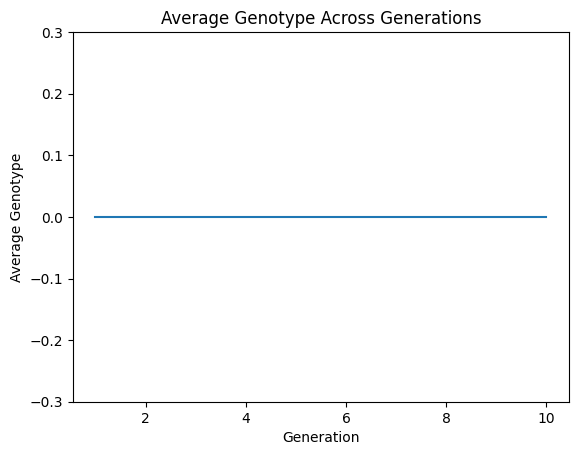

In [7]:
ten_gen_sim_assorted.plot_mean_genotype_across_generations()

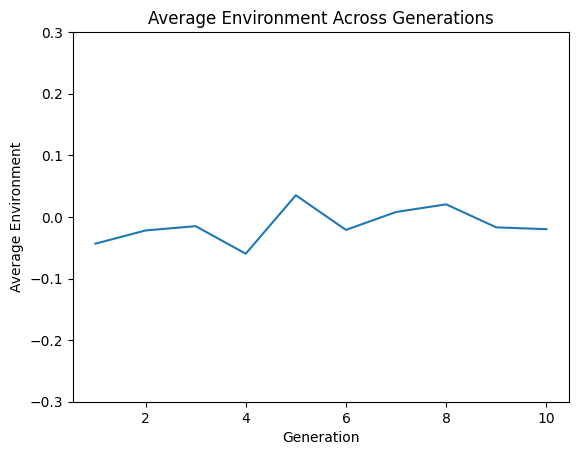

In [8]:
ten_gen_sim_assorted.plot_mean_environment_across_generations()

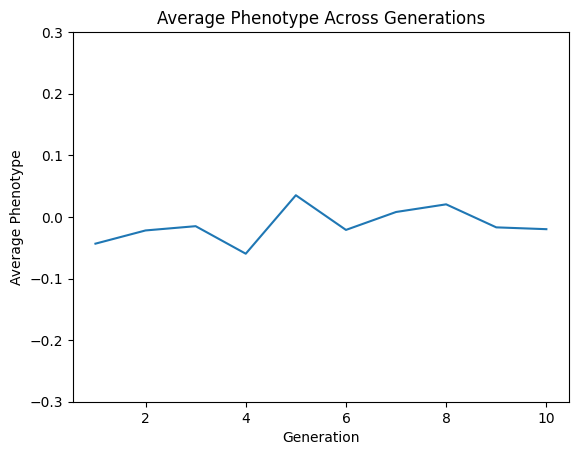

In [9]:
ten_gen_sim_assorted.plot_mean_phenotype_across_generations()

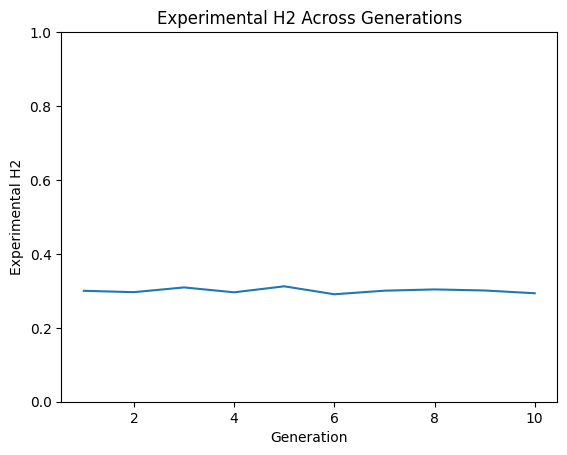

In [10]:
ten_gen_sim_assorted.plot_true_heritability()

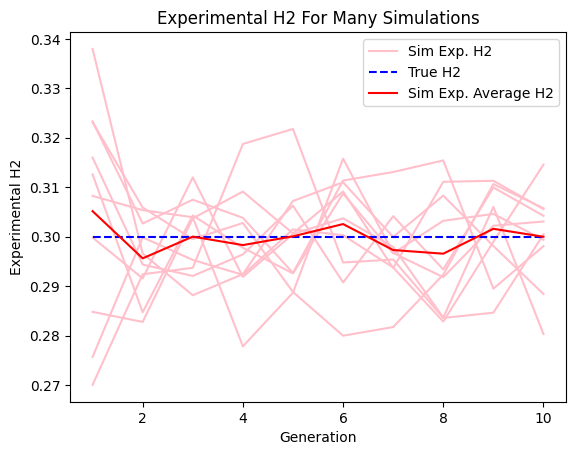

In [11]:
average_true_h2s = GenerationSimulator.many_sim_true_heritability(n=1000, s_noncausal=0, s_causal=500, true_h2=0.3, num_sims=10, assorted=True)

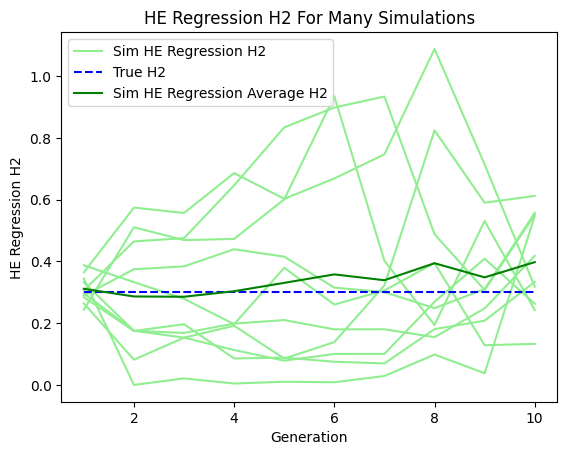

In [12]:
average_he_regression_h2s = GenerationSimulator.many_sim_he_regression(n=1000, s_noncausal=0, s_causal=500, true_h2=0.3, num_sims=10, assorted=True)

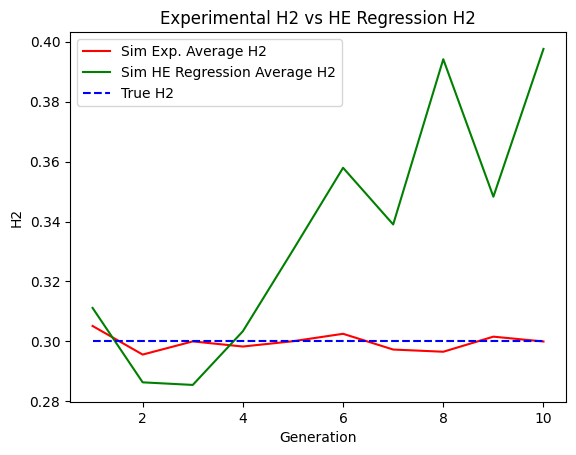

In [13]:
GenerationSimulator.plot_true_h2_and_he_regression(average_true_h2s, average_he_regression_h2s, true_h2=0.3)

##### This simulation is using assortative mating. In order to simulate assortative mating, I made random pairs of individuals from the parent generation, calculated the phenotypic correlation between parent 1s and parent 2s, and then shuffled a random pair and recalculated until the correlation = the desired correlation (0.3 +- 0.01). The genotype, environmental, and phenotypic graphs are not significantly different from the random mating situation, because though genotype frequencies may change due to assortative mating, the allele frequencies in the population do not change. The true experimental heritability still approximates the heritability without bias and without much noise, except for the first generation (in which assortative mating has not yet occurred). The first generation has more variable heritability estimates (the variance is approximately 0.1 more on both sides of the heritability than the other generations and the first generation using random mating). This is because the method of implementing heritability is slightly different in the first generation than in subsequent generations. In the first generation, genotypes and environment are simulated using va and ve. In subsequent generations, va is calculated from the genotypes and then ve is simulated to match the appropriate heritability. In subsequent generations, there is less variation in heritability as only the environmental component is drawn from a normal distribution - genotypes are guaranteed to have variance exactly va. Therefore, the decreased variability in subsequent generations compared to the first generation is an expected result of the simulation setup, and not due to assortative mating. Otherwise, the true experimental heritability approximates the simulation heritability (0.3) well. The HE regression estimate does not estimate the simulation heritability well. Based on the graphs of all simulations and on the average simulation value, the HE regression estimate is both noisy and biased. Looking at the simulations, there seems to be a pattern of the HE regression estimate either over or underestimating heritability, and then returning back to the true value. However, based on the average value, HE regresssion tends to overestimate heritability. This is because HE regression assumes random mating, so it overestimates the proportion of phenotypic similarity explained by genetic variance (Va) when the phenotypic similarity is actually due to genotypic similarity which is due to assortative mating. The assortative mating increases LD between causal variants in a way that HE regression doesn't predict. In other words, the assumption that covariance in genotype and phenotype is only due to additive genetic effects is not true. This paper supports my conclusion that assortative mating makes HE regression overestimate heritability: Border R, O'Rourke S, de Candia T, Goddard ME, Visscher PM, Yengo L, Jones M, Keller MC. Assortative mating biases marker-based heritability estimators. Nat Commun. 2022 Feb. However, over time (and over generations), the covariance in genotype and phenotype stops changing as rapidly compared to the first generation (no assortative mating) --> first few generations with assortative mating. When this happens, HE regression seems to be less biased, so the HE regression estimate trends back toward the simulation heritability.

##### F: Adding 950 non-causal SNPs

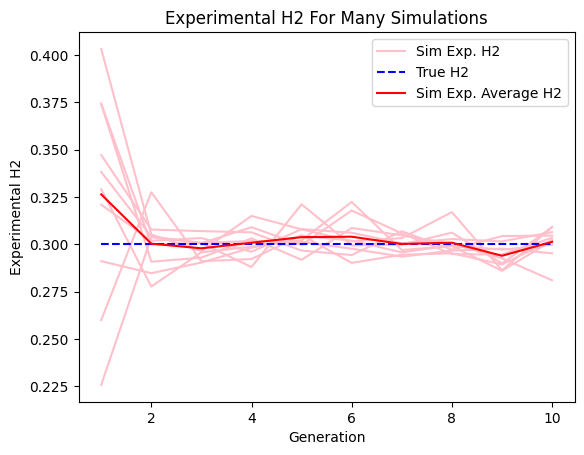

In [16]:
average_true_h2s = GenerationSimulator.many_sim_true_heritability(n=1000, s_noncausal=950, s_causal=50, true_h2=0.3, num_sims=10, assorted=True)

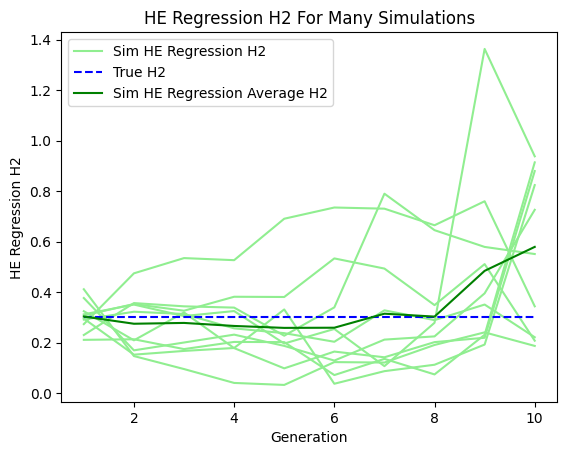

In [17]:
average_he_regression_h2s = GenerationSimulator.many_sim_he_regression(n=1000, s_noncausal=950, s_causal=50, true_h2=0.3, num_sims=10, assorted=True)

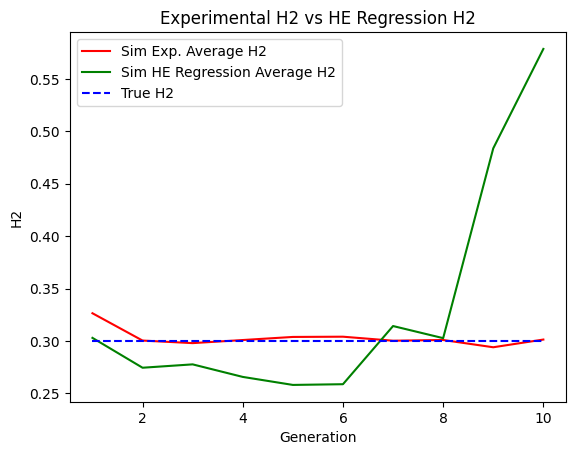

In [18]:
GenerationSimulator.plot_true_h2_and_he_regression(average_true_h2s, average_he_regression_h2s, true_h2=0.3)

##### In this simulation, I added 950 non-causal SNPs along with 50 causal SNPs. This caused the variance of the true experimental heritability estimate for the first generation to increase dramatically. This is most likely due to simply the decreased number of causal SNPs (necessary to make the simulation run in a reasonable time frame). Adding non-causal SNPs should not affect the genetic or environmental variance. This conclusion is in line with the immediate increase in precision of the heritability estimate in subsequent generations, as subsequent generations use the true genetic variance and simulation heritability to calculate the environmental variance. Since the number of causal SNPs would affect the genetic variance but not anything else, when the genetic variance is used to calculate the environmental variance, the precision of heritability is the same as previous simulations with no non-causal SNPs and 500 causal SNPs. This simulation also shows that the HE regression estimate of heritability still overestimates heritability, but later on in the generations. In early generations, the non-causal SNPs dilutes the covariance between genotypes and phenotypes, decreasing the heritability estimate from HE regression. This effect seems to counteract the effect of assortative mating, resulting in a heritability estimate that even underestimates the simulation heritability. In later generations (9-10), the non-causal SNPs become correlated with the causal SNPs because of assortative mating and linkage disequilibrium, and dilution effect is reduced, resulting once again in an overestimate of the heritability due to assumptions in HE regression violated due to assortative mating (explained above).

##### F: Decreasing simulation heritability

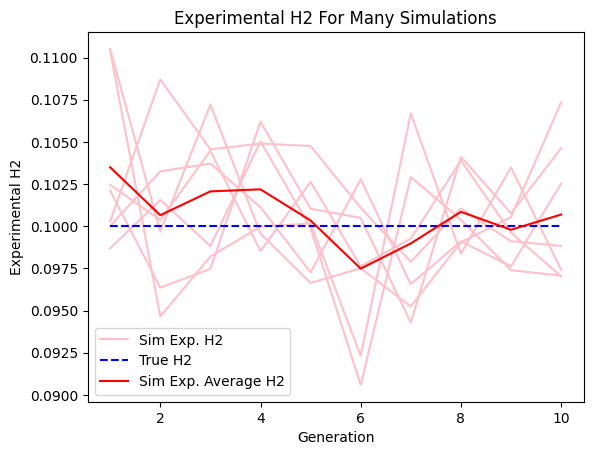

In [11]:
average_true_h2s = GenerationSimulator.many_sim_true_heritability(n=1000, s_noncausal=0, s_causal=500, true_h2=0.1, num_sims=7, assorted=True, target_corr=0.3)

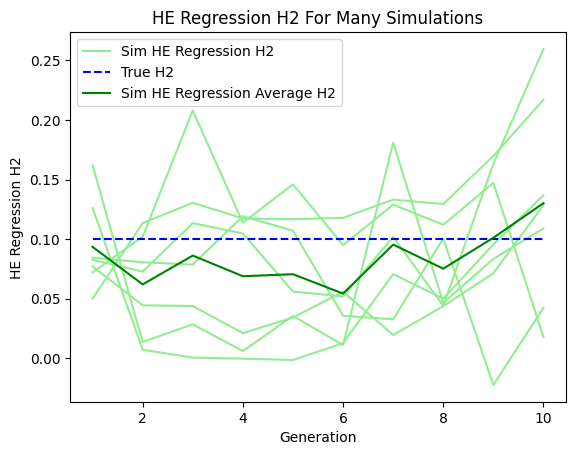

In [12]:
average_he_regression_h2s = GenerationSimulator.many_sim_he_regression(n=1000, s_noncausal=0, s_causal=500, true_h2=0.1, num_sims=7, assorted=True, target_corr=0.3)

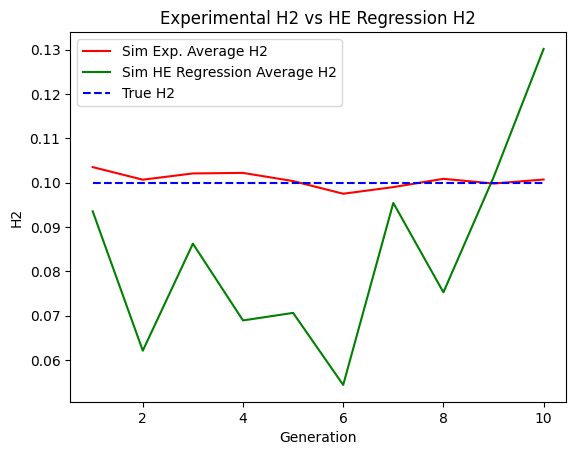

In [14]:
GenerationSimulator.plot_true_h2_and_he_regression(average_true_h2s, average_he_regression_h2s, true_h2=0.1)

##### Reducing the simulation heritability does not have an effect on the true experimental heritability of the simulation. It does have the effect of reducing the HE regression estimate of heritability for the early generations, and then overestimating it in later generations. In early generations, there is less covariance between phenotypes and genotypes because the simulation heritability is lower (compared to adding non-causal SNPs, which decreases the covariance due to added noise). In later generations, under assortative mating, the LD between causal variants builds up, and individuals with similar genotypes become more phenotypically similar than what the HE regression model predicts, offsetting the effect of decreased simulation heritability. Since genotype-phenotype correlation is higher in higher kinship, the HE regression overestimates heritability in later generations.